In [27]:
import pandas as pd
import json
import random

random.seed(42)

In [28]:
with open('./data/json_data_result_1_3000.json', 'r') as f:
    raw_data: dict = json.load(f)

In [29]:
cnt = 0
info_object = {}
def _add(key, val):
    if key not in info_object:
        info_object[key] = []
    info_object[key].append(val)

for crt_name, avatar_info_list in raw_data.items():
    for avatar_info in avatar_info_list:
        _add('name', crt_name)
        for k, v in avatar_info.items():
            _add(k, v)

raw_df = pd.DataFrame(info_object)
raw_df.head()

,name,face,cap,longcoat,weapon,cape,coat,glove,hair,pants,shield,shoes,faceAccessory,eyeAccessory,earrings,skin
0,오지환,51051,1001147,1051731,1703254,1103505,0,1082102,47770,0,1353203,1073686,1012402,1022079,1032024,12019
1,오지환,51051,1006011,1051713,1703217,1103459,0,1082102,48651+5*60,0,1353203,1071160,1012402,1022079,1032024,12019
2,오지환,24055,1006011,1051713,1703217,1103459,0,1082102,61501+0*70,0,1353203,1071160,1012402,1022079,1032024,12019
3,오지환,24055,1006011,1051713,1703217,1103459,0,1082102,61501+0*70,0,1353203,1071160,1012632,1022079,1032024,12019
4,오지환,24055,1005268,1051512,1702807,1102039,0,1082102,61501+0*70,0,1353203,1073415,1012402,1022079,1032024,12019


In [30]:
df = raw_df.copy()

def extract_hair_base(hair: str):
    if "+" not in hair:
        return hair
    return hair.split('+')[0]

df["hair"] = df["hair"].map(extract_hair_base)
df.head()

,name,face,cap,longcoat,weapon,cape,coat,glove,hair,pants,shield,shoes,faceAccessory,eyeAccessory,earrings,skin
0,오지환,51051,1001147,1051731,1703254,1103505,0,1082102,47770,0,1353203,1073686,1012402,1022079,1032024,12019
1,오지환,51051,1006011,1051713,1703217,1103459,0,1082102,48651,0,1353203,1071160,1012402,1022079,1032024,12019
2,오지환,24055,1006011,1051713,1703217,1103459,0,1082102,61501,0,1353203,1071160,1012402,1022079,1032024,12019
3,오지환,24055,1006011,1051713,1703217,1103459,0,1082102,61501,0,1353203,1071160,1012632,1022079,1032024,12019
4,오지환,24055,1005268,1051512,1702807,1102039,0,1082102,61501,0,1353203,1073415,1012402,1022079,1032024,12019


In [31]:
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder

train_df, test_df = model_selection.train_test_split(df, test_size=0.05, random_state=42)

def extract_xy(df, idx):
    column_list = train_df.columns.tolist()
    x_col = column_list[1:idx] + column_list[idx + 1:]
    y_col = [column_list[idx]]
    X = train_df[x_col]
    for col_name in X.columns:
        X[col_name] = X[col_name].astype('category')
    y = train_df[y_col]
    return X, y

def train(want_to_classify_idx: int):
    X, y = extract_xy(train_df, want_to_classify_idx)
    le = LabelEncoder()
    le.fit(y)
    transformed_y = le.transform(y)

    model = XGBClassifier(
        n_estimators=20,
        max_depth=5,
        learning_rate=0.1,
        tree_method="hist",
        objective='multi:softmax',
        enable_categorical=True,
    )
    print(X.head(10))
    xgb_model = model.fit(
        X,
        transformed_y,
    )
    return xgb_model, le
 
model, le = train(1)

/tmp/ipykernel_1092/2466644038.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col_name] = X[col_name].astype('category')
/tmp/ipykernel_1092/2466644038.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col_name] = X[col_name].astype('category')
/tmp/ipykernel_1092/2466644038.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

           cap longcoat   weapon     cape coat    glove   hair pants   shield  \
3559   1005656  1053640  1703047  1103400    0  1082102  60674     0  1353703   
3421   1005805  1050474  1703115  1102918    0  1082102  60470     0  1352972   
5863   1002083  1050591  1703141  1103400    0  1082102  46601     0  1353403   
2546   1004453  1052671  1702565  1102039    0  1082102  35664     0  1352932   
2039   1006082  1050656  1703252        0    0        0  46440     0  1352212   
5361   1000121  1050657  1703253  1102039    0  1082774  60674     0  1352922   
11075  1005835  1050594  1703115  1103357    0  1082102  46890     0  1354003   
16443  1000121  1050657  1703253  1102039    0  1082102  60315     0  1354003   
3941   1006011  1051713  1703217  1103459    0  1082102  61190     0  1354003   
13069  1005835  1050594  1703115  1103357    0  1082657  60460     0  1352212   

         shoes faceAccessory eyeAccessory earrings   skin  
3559   1072153       1012289      1022079  10320

In [32]:
tx, ty = extract_xy(test_df, 1)
py = model.predict(tx)

/tmp/ipykernel_1092/2466644038.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col_name] = X[col_name].astype('category')
/tmp/ipykernel_1092/2466644038.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col_name] = X[col_name].astype('category')
/tmp/ipykernel_1092/2466644038.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [35]:
predicted_ys = le.inverse_transform(py)
real_ys = ty

predicted_ys_list = predicted_ys.tolist()
real_ys_list = real_ys[real_ys.columns[0]].tolist()

predicted_set = tx.copy()
predicted_set["face"] = predicted_ys_list

real_set = tx.copy()
real_set["face"] = real_ys_list

print(predicted_set.head())
print(predicted_set.head())


          cap longcoat   weapon     cape coat    glove   hair pants   shield  \
3559  1005656  1053640  1703047  1103400    0  1082102  60674     0  1353703   
3421  1005805  1050474  1703115  1102918    0  1082102  60470     0  1352972   
5863  1002083  1050591  1703141  1103400    0  1082102  46601     0  1353403   
2546  1004453  1052671  1702565  1102039    0  1082102  35664     0  1352932   
2039  1006082  1050656  1703252        0    0        0  46440     0  1352212   

        shoes faceAccessory eyeAccessory earrings   skin   face  
3559  1072153       1012289      1022079  1032024  12015  21378  
3421  1073489       1012083      1022285  1032024  12015  20647  
5863  1073489       1012000      1022079  1032024  12018  21578  
2546  1073425       1012289      1022079  1032024  12015  20147  
2039  1073684       1012289      1022079  1032024  12015  27065  
          cap longcoat   weapon     cape coat    glove   hair pants   shield  \
3559  1005656  1053640  1703047  1103400   

/home/changsu/project/maple-cody-recommendation-system/.venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host '0.0.0.0'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


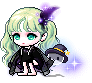

/home/changsu/project/maple-cody-recommendation-system/.venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host '0.0.0.0'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


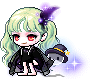

/home/changsu/project/maple-cody-recommendation-system/.venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host '0.0.0.0'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


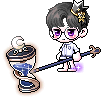

/home/changsu/project/maple-cody-recommendation-system/.venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host '0.0.0.0'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


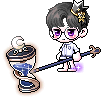

/home/changsu/project/maple-cody-recommendation-system/.venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host '0.0.0.0'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


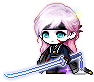

/home/changsu/project/maple-cody-recommendation-system/.venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host '0.0.0.0'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


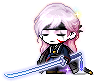

/home/changsu/project/maple-cody-recommendation-system/.venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host '0.0.0.0'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


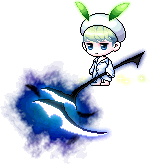

/home/changsu/project/maple-cody-recommendation-system/.venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host '0.0.0.0'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


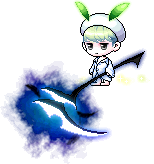

/home/changsu/project/maple-cody-recommendation-system/.venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host '0.0.0.0'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


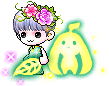

/home/changsu/project/maple-cody-recommendation-system/.venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host '0.0.0.0'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


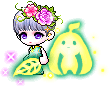

/home/changsu/project/maple-cody-recommendation-system/.venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host '0.0.0.0'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


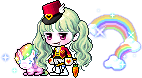

/home/changsu/project/maple-cody-recommendation-system/.venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host '0.0.0.0'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


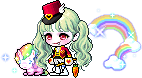

/home/changsu/project/maple-cody-recommendation-system/.venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host '0.0.0.0'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


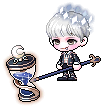

/home/changsu/project/maple-cody-recommendation-system/.venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host '0.0.0.0'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


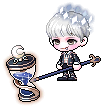

/home/changsu/project/maple-cody-recommendation-system/.venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host '0.0.0.0'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


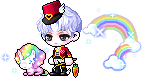

/home/changsu/project/maple-cody-recommendation-system/.venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host '0.0.0.0'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


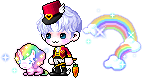

/home/changsu/project/maple-cody-recommendation-system/.venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host '0.0.0.0'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


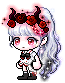

/home/changsu/project/maple-cody-recommendation-system/.venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host '0.0.0.0'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


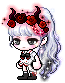

/home/changsu/project/maple-cody-recommendation-system/.venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host '0.0.0.0'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


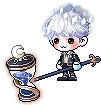

/home/changsu/project/maple-cody-recommendation-system/.venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host '0.0.0.0'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


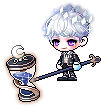

/home/changsu/project/maple-cody-recommendation-system/.venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host '0.0.0.0'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7f868961b130>

In [38]:
import requests
from PIL import Image
from io import BytesIO
import base64

def get_image(x):
    obj = {}
    for k, v in x.items():
        if k == 'skin':
            k = 'head'
        if k == 'shield':
            continue
        if v == '0':
            continue
        if k == 'name':
            continue
        obj[k] = v
    obj['bs']='true'
    res = requests.get('https://0.0.0.0:7209/avatar', params=obj, verify=False)
    return Image.open(BytesIO(base64.b64decode(res.text)))

for idx in range(0,100):
    try:
        a = predicted_set.iloc[idx, :]
        b = real_set.iloc[idx, :]
        R = get_image(a)
        R = get_image(b)
        R.show()
        R.show()
    except:
        continue

